## Compare Sagnac Frequency and Beam Power

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Stream, Trace
from numpy import array

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

config['seed'] = "BW.DROMY..FJZ"

# config['filename'] = "FJZ_powermeter_2"
# config['filename'] = "FJZ_powermeter_20230602"

## new test with good RZ sagnac contrast
# config['filename'] = "FJZ_powermeter_20230602"
config['filename'] = "FJZ_powermeter_20230605"


config['tbeg'] = UTCDateTime("2023-06-05 12:00")
config['tend'] = UTCDateTime("2023-06-05 23:30")

config['datapath'] = data_path+"sagnac_frequency/beampower/"
config['data_sagnac'] = data_path+"sagnac_frequency/autodata/"

## Create PKL and MSEED files

In [4]:
# filename = config['filename']

# ## read data
# df = read_csv(config['datapath']+filename+".csv", header=4, delimiter="\t", names=["power_W", "time_ms"])

# ## write as pickle file
# df.to_pickle(config['datapath']+filename+".pkl")

# ## get start time and convert to UTC
# dt = read_csv(config['datapath']+filename+".csv", nrows=1, delimiter="\t", names=["datetime"]).datetime[0]
# dt = UTCDateTime(dt) - 7200

# ## sampling rate
# delta_t = 300*1e-3 ## seconds

# ## cut some samples at the start with light still on...
# n_samples_to_cut = 4000

# ## create trace object
# tr = Trace()
# tr.data = array(df['power_W'][n_samples_to_cut:])
# tr.stats.starttime = dt+n_samples_to_cut*delta_t
# tr.stats.delta = delta_t

# ## write as stream object
# st = Stream()
# st += tr
# st.write(config['datapath']+filename+".mseed", format="MSEED")
# st.plot();

## Load Data

In [5]:
def __load_data(config):
    
    net, sta, loc, cha = config['seed'].split(".")
    
    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = cha+"_"+str(dat)[:10].replace("-","")+".pkl"

        try:
            df0 = read_pickle(config['data_sagnac']+file)
            df = concat([df, df0])
        except:
            print(f"error for {config['data_sagnac']}{file}")
            
    return df

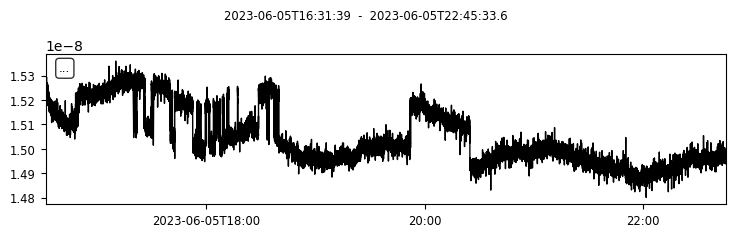

In [34]:
config['seed'] = "BW.DROMY..FJZ"
fjz = __load_data(config)

power = read(config['datapath']+config['filename']+"_2.mseed")
power.plot();


In [8]:
from andbro__utc_to_mjd import __utc_to_mjd

times_mjd = __utc_to_mjd(list(power[0].times("utcdatetime")))

In [9]:
## creating dataframe
power_df = DataFrame()

power_df['power_W'] = power[0].data
power_df['times_mjd'] = times_mjd


In [10]:
## Trimming fjz
fjz = fjz[(fjz.times_mjd >= power_df.times_mjd[0]) & (fjz.times_mjd <= power_df.times_mjd[len(power_df.times_mjd)-1])]


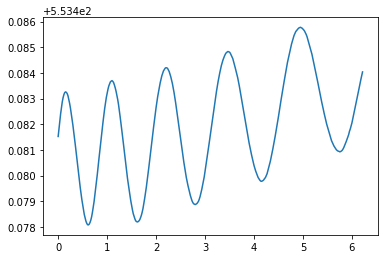

In [11]:
plt.plot((fjz.times_utc-fjz['times_utc'].iloc[0])/3600, fjz.fz)

## Plot Power

In [12]:
def __makeplot_beampower(df1, df2):

    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

    #         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth

    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
    ax[0].scatter(df1['times_mjd'], df1['fz'], c="black", s=12, alpha=0.4, zorder=2)
    ax[0].plot(df1['times_mjd'], df1['fz'], c="black", alpha=0.9, zorder=2, label="FJZ")
    
    
    ## DF2
#     ax[1].scatter(df2['times_mjd'], df2['power_W'], c="#f48512", s=10, alpha=0.4, zorder=2, label="F1Z*")
    ax[1].plot(df2['times_mjd'], df2['power_W']*1e9, c="#f48512", alpha=0.9, zorder=2)

    ax1_2= ax[1].twinx()
    ax1_2.plot(df1['times_mjd'], df1['pz'], c="tab:blue", alpha=0.9, zorder=2, label="FJZ")
    ax1_2.tick_params(axis="y", colors="tab:blue")
    
    ax1_3= ax[1].twinx()
    ax1_3.plot(df1['times_mjd'], df1['contrast_z'], c="tab:green", alpha=0.8, zorder=2, label="FJZ")
    ax1_3.tick_params(axis="y", colors="tab:green")
        
    ax1_3.spines['right'].set_position(('axes', 1.1 ))
    ax1_3.set_ylabel("contrast", color="tab:green", fontsize=font)

#     ax[0].set_yscale("log")
#     ax[1].set_yscale("log")
    
    ax[0].set_ylabel(r"Beat Note (Hz)", fontsize=font)
    ax[1].set_ylabel(r"Beam Power (nW)", fontsize=font)
    ax1_2.set_ylabel(r"PSD$_{max} (V^2/Hz)$", fontsize=font, color="#3776ab")

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
    ax[0].legend(loc=4)
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
           
    ax[0].tick_params(labelsize=font-2)   
    ax[1].tick_params(labelsize=font-2)   
    ax1_2.tick_params(labelsize=font-2)   
    ax1_3.tick_params(labelsize=font-2)   
    
    ax[0].set_title(f"ROMY RZ on {config['tbeg'].date}", fontsize=font+1)    
#     for i in range(2):
#         ax[i].grid(zorder=0)
    
    plt.show();

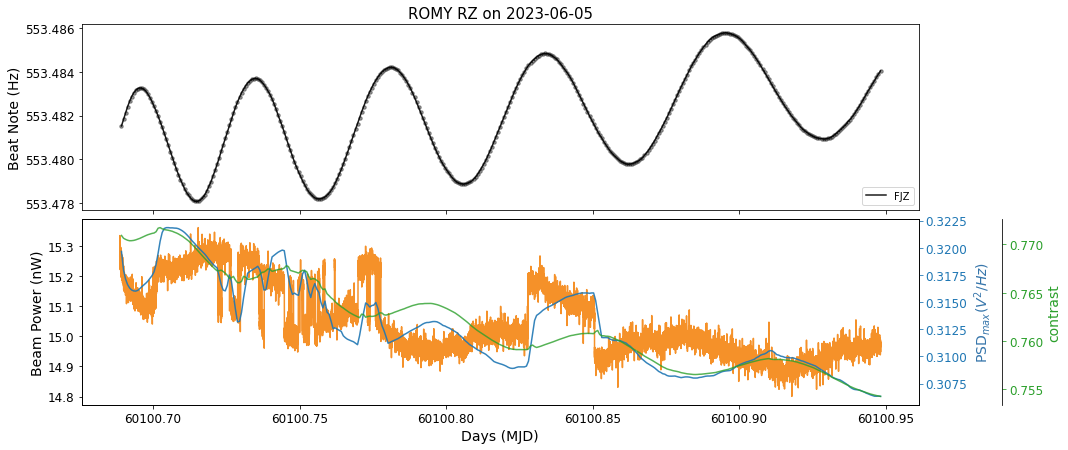

In [13]:
__makeplot_beampower(fjz, power_df)

(0.28, 0.35)

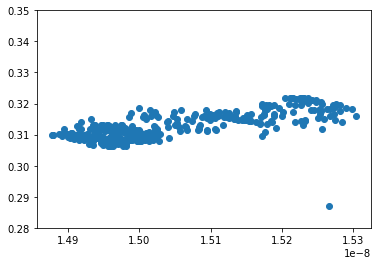

In [30]:
from numpy import interp
new = interp(fjz.times_mjd, power_df.times_mjd, power_df.power_W)
plt.scatter(new, fjz.pz)
plt.ylim(0.28, 0.35)

## Plot Power two dataset joint

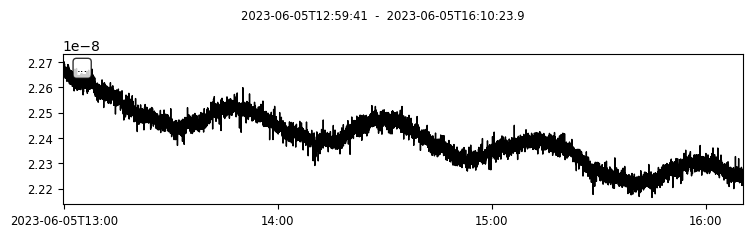

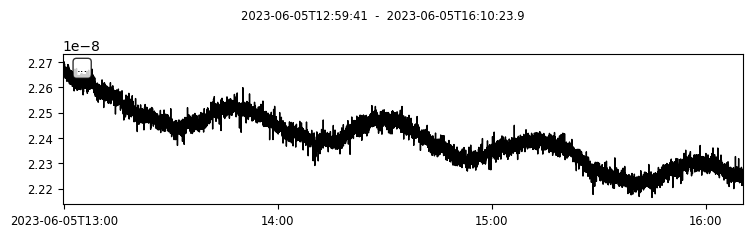

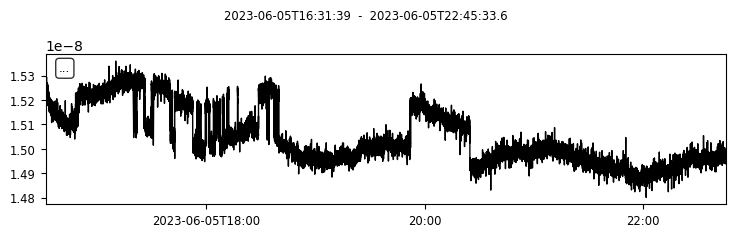

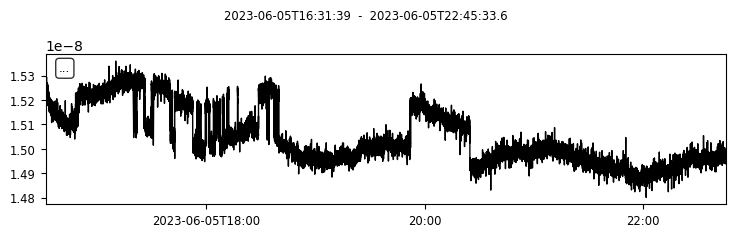

In [14]:
config['seed'] = "BW.DROMY..FJZ"
fjz = __load_data(config)

power1 = read(config['datapath']+config['filename']+"_1.mseed")
power1.plot();

power2 = read(config['datapath']+config['filename']+"_2.mseed")
power2.plot();

from andbro__utc_to_mjd import __utc_to_mjd

times_mjd_1 = __utc_to_mjd(list(power1[0].times("utcdatetime")))
times_mjd_2 = __utc_to_mjd(list(power2[0].times("utcdatetime")))

## creating dataframe
power1_df = DataFrame()

power1_df['power_W'] = power1[0].data
power1_df['times_mjd'] = times_mjd_1

## creating dataframe
power2_df = DataFrame()

power2_df['power_W'] = power2[0].data
power2_df['times_mjd'] = times_mjd_2

fjz = fjz[(fjz.times_mjd >= power1_df.times_mjd[0]) & (fjz.times_mjd <= power2_df.times_mjd[len(power2_df.times_mjd)-1])]

In [15]:
def __makeplot_beampower2(df1, df2, df3):

    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

    #         win = ones(box_pts)/box_pts
        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth

    
    ## ___________________
    ##
    
    fig, ax = plt.subplots(2,1, figsize=(15,7), sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    font = 14
    smooting = 10
    cut_off = int(smooting/2)
    
    ## DF1
#     ax[0].scatter(df1['times_mjd'], df1['fz'], c="black", s=12, alpha=0.4, zorder=2)
    ax[0].plot(df1['times_mjd'], df1['fz'], c="black", alpha=0.8, zorder=2, label="FJZ")
    
    
    ## DF2
    ax[1].plot(df2['times_mjd'], df2['power_W']*1e9, c="#f48512", alpha=0.8, zorder=2)
    ax[1].plot(df3['times_mjd'], df3['power_W']*1e9, c="#f48512", alpha=0.8, zorder=2)

    
    ax1_2= ax[1].twinx()
    ax1_2.plot(df1['times_mjd'], df1['pz'], c="tab:blue", alpha=0.8, zorder=2, label="FJZ")
    ax1_2.tick_params(axis="y", colors="tab:blue")
    
    ax1_3= ax[1].twinx()
    ax1_3.plot(df1['times_mjd'], df1['contrast_z'], c="tab:green", alpha=0.8, zorder=2, label="FJZ")
    ax1_3.tick_params(axis="y", colors="tab:green")
    

#     ax[0].set_yscale("log")
#     ax[1].set_yscale("log")
    
    ax[0].set_ylabel(r"Beat Note (Hz)", fontsize=font)
    ax[1].set_ylabel(r"Power (nW)", fontsize=font)
    ax1_2.set_ylabel(r"PSD$_{max} (V^2/Hz)$", fontsize=font, color="#3776ab")

    ax[1].set_xlabel("Days (MJD)", fontsize=font)
    
    ax[0].legend(loc=4)
    
    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[1].ticklabel_format(useOffset=False, style='plain')
           
    for i in range(2):
        ax[i].grid(zorder=0)
    
    plt.show();

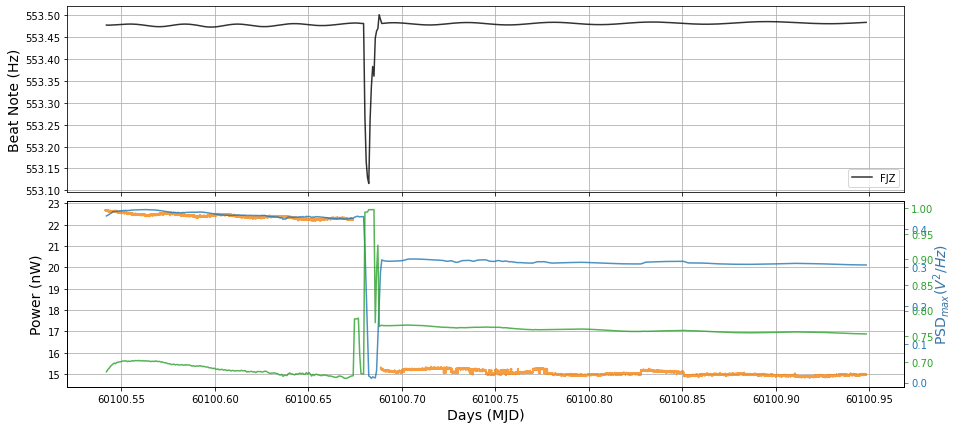

In [16]:
__makeplot_beampower2(fjz, power1_df, power2_df)